In [94]:
1+1

2

In [95]:
 %cd /sci/labs/yotamd/lab_share/avishai.wizel/eRNA/

/sci/labs/yotamd/lab_share/avishai.wizel/eRNA


/sci/labs/yotamd/lab_share/avishai.wizel/python_envs/miniconda/envs/tf_gpu_env/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [96]:
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, auc
from scipy.sparse import issparse


# Main parameters

In [97]:
top_rna_var_genes = 2500
top_var_peaks = 500
n_estimators= 4
max_depth = 10
max_features = 0.5
min_samples_leaf= 10

# Load data

In [98]:
sc_rna = ad.read_h5ad('./10X_PBMC/03_filtered_data/filtered_rna_adata.h5ad')
sc_atac = ad.read_h5ad("./10X_PBMC/03_filtered_data/filtered_atac_adata.h5ad")

/sci/labs/yotamd/lab_share/avishai.wizel/python_envs/miniconda/envs/tf_gpu_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Filters cells

In [99]:
def filter_cells_by_qc_metrics(
    adata: ad.AnnData,
    min_genes: int = 200,
    max_genes: int = 2500,
    min_counts: int = 1000,
    max_mt_pct: float = 40.0
) -> ad.AnnData:
    """
    Filters cells based on standard quality control metrics:
    number of genes detected, total counts, and mitochondrial gene percentage.

    Args:
        adata (anndata.AnnData):
            The AnnData object containing raw gene expression counts (cells x genes).
            Assumes mitochondrial genes are prefixed with 'MT-' (human) or 'mt-' (mouse).
        min_genes (int): Minimum number of genes expressed per cell.
        max_genes (int): Maximum number of genes expressed per cell (to remove doublets).
        min_counts (int): Minimum total counts per cell.
        max_mt_pct (float): Maximum allowed percentage of mitochondrial counts per cell.

    Returns:
        anndata.AnnData: A new AnnData object with filtered cells.
                         QC metrics are added to adata.obs.
    """
    
    # Ensure adata.var['mt'] is set if not already
    if 'mt' not in adata.var:
        # Assuming human data with 'MT-' prefix. Adjust for mouse ('mt-') or other.
        adata.var['mt'] = adata.var_names.str.startswith('MT-') 

    print("Calculating QC metrics...")
    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=['mt'], 
        percent_top=None, 
        log1p=False, 
        inplace=True
    )

    print(f"Original number of cells: {adata.n_obs}")
    
    # Apply filters
    initial_cells_count = adata.n_obs
    
    # Combine filtering criteria using boolean logic
    cells_to_keep = (
        (adata.obs['n_genes_by_counts'] >= min_genes) &
        (adata.obs['n_genes_by_counts'] <= max_genes) &
        (adata.obs['total_counts'] >= min_counts) &
        (adata.obs['pct_counts_mt'] <= max_mt_pct)
    )
    
    adata_filtered = adata[cells_to_keep, :].copy()
    
    filtered_cells_count = adata_filtered.n_obs
    removed_cells_count = initial_cells_count - filtered_cells_count
    
    print(f"Cells removed: {removed_cells_count}")
    print(f"Number of cells after filtering: {filtered_cells_count}")

    return adata_filtered

In [100]:
adata_filtered_qc = filter_cells_by_qc_metrics(
    sc_rna.copy(),
    min_genes=200,
    max_genes=2500,
    min_counts=500,
    max_mt_pct=25
)

/sci/labs/yotamd/lab_share/avishai.wizel/python_envs/miniconda/envs/tf_gpu_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Calculating QC metrics...
Original number of cells: 11852
Cells removed: 2502
Number of cells after filtering: 9350


/sci/labs/yotamd/lab_share/avishai.wizel/python_envs/miniconda/envs/tf_gpu_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Normalize scRNA-seq

In [101]:
# 1. Size Normalization
sc.pp.normalize_total(adata_filtered_qc, target_sum=1e4)

# 2. Log-transformation (log1p)
sc.pp.log1p(adata_filtered_qc)
sc.pp.highly_variable_genes(adata_filtered_qc, n_top_genes=top_rna_var_genes, flavor='seurat')


Take only high variable genes:

In [102]:
sc_rna_filtered = adata_filtered_qc[:, adata_filtered_qc.var.highly_variable].copy()

# filter atac cells based on filtered rna cells
filtered_cell_barcodes = sc_rna_filtered.obs_names
adata_atac_filtered = sc_atac[sc_atac.obs_names.isin(filtered_cell_barcodes), :].copy()
adata_atac_filtered = sc_atac[filtered_cell_barcodes, :].copy()



# Filter for highly variable peaks

In [103]:
def get_top_n_highly_variable_peaks(adata_atac: ad.AnnData, n_top_peaks: int = 10000) -> ad.AnnData:
    """
    Identifies and keeps the top N highly variable peaks in an AnnData object
    based on their variance-to-mean ratio (a proxy for dispersion).

    Args:
        adata_atac (anndata.AnnData):
            The AnnData object containing ATAC-seq data (cells x peaks).
            Assumes adata_atac.X contains counts or binarized values.
        n_top_peaks (int):
            The number of top highly variable peaks to select.

    Returns:
        anndata.AnnData: An AnnData object subsetted to include only the selected top N peaks.
                         Statistical information is added to adata_atac.var.
    """
    
    print(f"Original AnnData shape (cells x peaks): {adata_atac.shape}")

    # Convert to dense for calculation if sparse, using float32 for memory efficiency
    data = adata_atac.X.toarray().astype(np.float32) if issparse(adata_atac.X) else adata_atac.X.astype(np.float32)
    
    # Calculate mean and variance for each peak (column-wise)
    peak_means = np.mean(data, axis=0)
    peak_variances = np.var(data, axis=0)
    
    # Avoid division by zero for peaks with zero mean
    # A common approach is to add a small constant to the mean or handle NaN results.
    # For ATAC (binary), peaks with zero mean have zero variance and are not variable.
    # We'll set dispersion to 0 for these or filter them out.
    
    # Calculate variance-to-mean ratio as a measure of dispersion
    # Adding a small epsilon to avoid division by zero
    epsilon = 1e-6 
    dispersion = peak_variances / (peak_means + epsilon)
    
    # Store these metrics in adata.var
    adata_atac.var['peak_means'] = peak_means
    adata_atac.var['peak_variances'] = peak_variances
    adata_atac.var['peak_dispersion'] = dispersion

    # Rank peaks by dispersion and select top N
    # Sort in descending order
    adata_atac.var['ranked_dispersion'] = adata_atac.var['peak_dispersion'].rank(ascending=False, method='first')
    
    selected_peaks = adata_atac.var[adata_atac.var['ranked_dispersion'] <= n_top_peaks].index
    
    adata_filtered_peaks = adata_atac[:, selected_peaks].copy()
    
    print(f"AnnData shape after filtering to top {n_top_peaks} highly variable peaks: {adata_filtered_peaks.shape}")
    
    return adata_filtered_peaks


In [104]:
adata_hvps = get_top_n_highly_variable_peaks(adata_atac_filtered.copy(), top_var_peaks)


Original AnnData shape (cells x peaks): (9350, 67207)
AnnData shape after filtering to top 500 highly variable peaks: (9350, 500)


In [105]:
scRNA = sc_rna_filtered.X
scATAC_binary = adata_hvps.X.toarray()
del(sc_rna)
del(sc_atac)
del(adata_atac_filtered)
del(sc_rna_filtered)

In [106]:
print("scRNA dim (cells X genes):" ,scRNA.shape)
print("scATAC dim (cells X peaks):" ,scATAC_binary.shape)

scRNA dim (cells X genes): (9350, 2500)
scATAC dim (cells X peaks): (9350, 500)


# Train

In [107]:
X_train, X_test, y_train, y_test = train_test_split(scRNA, scATAC_binary, test_size=0.2, random_state=42)

In [108]:
# --- Model Initialization ---
# Create a Random Forest Regressor model.
# n_estimators: Number of trees in the forest (you can adjust this value).
# random_state: For reproducible results.
# n_jobs=-1: Uses all available CPU cores for parallel processing during training.
rf_model = RandomForestClassifier(n_estimators=n_estimators,
                                  random_state=42, n_jobs=-1, verbose=3,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  min_samples_leaf= min_samples_leaf
                                 )


In [109]:
# --- Model Training ---
print("Starting Random Forest training...")
rf_model.fit(X_train, y_train)
print("Random Forest training completed.")


Starting Random Forest training...
building tree 1 of 4
building tree 2 of 4
building tree 3 of 4
building tree 4 of 4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Random Forest training completed.


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   17.5s finished


# Preditct

In [110]:
# ---  Perform Predictions ---
# predict() returns the predicted class (0 or 1) for each output (peak).
y_pred_binary = rf_model.predict(X_test)

# predict_proba() returns the probabilities for each class (0 and 1).
# For multi-output classification (like predicting multiple peaks),
# predict_proba will return a LIST of arrays.
# Each array in the list corresponds to one output (one peak)
# and has shape (n_samples, 2), where the 2 columns are (probability_of_class_0, probability_of_class_1).
y_pred_proba = rf_model.predict_proba(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


# Evaluate

## Accuracy (less informative)

In [111]:
# --- Evaluate Model Performance ---

# A. Overall Accuracy (simpler, but less informative for highly imbalanced data)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nOverall Accuracy: {accuracy:.4f}")

# B. Per-output (Per-peak) metrics for multi-output classification
f1_scores = []
precision_scores = []
recall_scores = []
roc_auc_scores = [] # ROC AUC requires probability predictions




Overall Accuracy: 0.4989


## F1-Score, ROC AUC

In [112]:

# Iterate through each output (each peak) to calculate its specific metrics
for i in range(y_test.shape[1]):
    # Get true labels for the current peak.
    true_labels_peak = y_test.iloc[:, i] if isinstance(y_test, pd.DataFrame) else y_test[:, i]
    
    # Get predicted labels (0 or 1) for the current peak.
    pred_labels_peak = y_pred_binary[:, i]
    
    # --- FIX FOR IndexError ---
    # Check the shape of the probability array for the current peak
    # y_pred_proba[i] is an array of probabilities for the i-th peak
    
    # Check if the array has 2 columns (for prob_0 and prob_1)
    if y_pred_proba[i].shape[1] == 2:
        pred_proba_peak_positive = y_pred_proba[i][:, 1] # Probability of class 1
        has_two_classes_in_predictions = True
    else:
        # This happens if the model only predicted one class for this specific output.
        # This means all predictions for this peak were 0 (or all 1, less likely).
        # In such cases, predict_proba returns only one column.
        # We need to decide how to handle this for ROC AUC.
        # If the true labels are also only one class, ROC AUC is undefined anyway.
        # If all predictions are 0, then the probability of 1 is effectively 0 for all.
        pred_proba_peak_positive = np.zeros_like(pred_labels_peak, dtype=float) # All predictions are 0, so prob of 1 is 0
        has_two_classes_in_predictions = False # Mark that the model did not predict two classes
        
    # Calculate F1-Score, Precision, and Recall for the current peak.
    f1_scores.append(f1_score(true_labels_peak, pred_labels_peak, zero_division=0))
    precision_scores.append(precision_score(true_labels_peak, pred_labels_peak, zero_division=0))
    recall_scores.append(recall_score(true_labels_peak, pred_labels_peak, zero_division=0))

    # ROC AUC calculation: only if there's more than one class present in the true labels for this peak AND
    # if the model predicted probabilities for both classes (has_two_classes_in_predictions)
    if len(np.unique(true_labels_peak)) > 1 and has_two_classes_in_predictions:
        roc_auc_scores.append(roc_auc_score(true_labels_peak, pred_proba_peak_positive))
    else:
        # If only one class is present in true labels OR model only predicted one class, ROC AUC is undefined or meaningless.
        roc_auc_scores.append(np.nan)


print(f"Average F1-Score (across all peaks): {np.nanmean(f1_scores):.4f}")
print(f"Average Precision (across all peaks): {np.nanmean(precision_scores):.4f}")
print(f"Average Recall (across all peaks): {np.nanmean(recall_scores):.4f}")
print(f"Average ROC AUC (across all peaks): {np.nanmean(roc_auc_scores):.4f} (NaNs indicate peaks with only one class or model prediction of one class)")

# Important: If you get many NaNs for ROC AUC, it means many peaks have only 0s in the test set.
# This is expected due to high sparsity. Also, if the model predicts all 0s for a peak due to
# only seeing 0s in training for that peak, its predict_proba will return only one column,
# leading to NaN for ROC AUC.

Average F1-Score (across all peaks): 0.0049
Average Precision (across all peaks): 0.0075
Average Recall (across all peaks): 0.0039
Average ROC AUC (across all peaks): 0.7918 (NaNs indicate peaks with only one class or model prediction of one class)


Average ROC AUC (across all peaks): 0.7918 (NaNs indicate peaks with only one class or model prediction of one class)

Note: Only plotted 20 individual ROC curves for clarity.


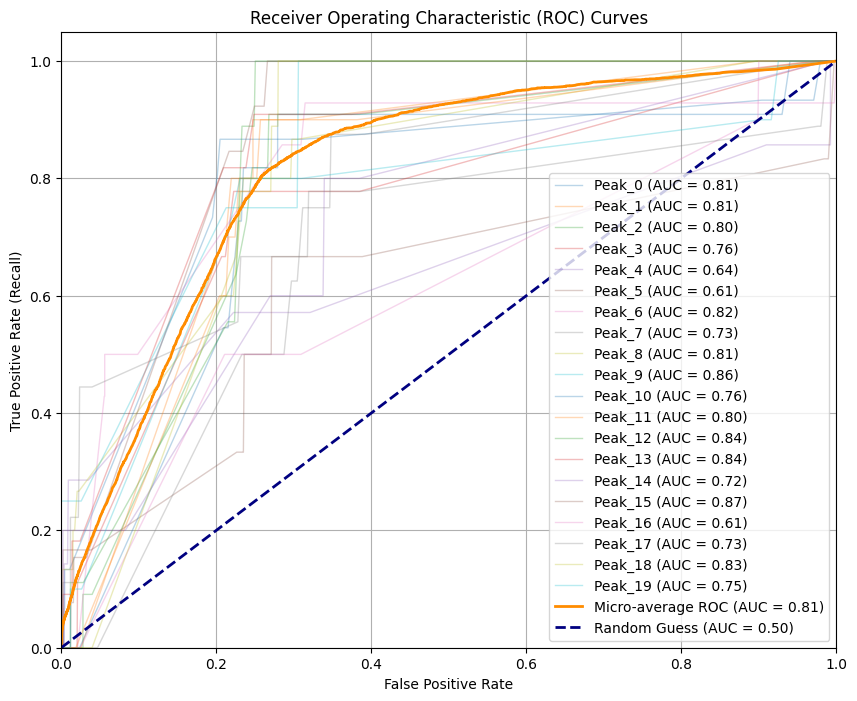

In [130]:
from sklearn.metrics import roc_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve

# Initialize lists to store metrics
f1_scores = []
precision_scores = []
recall_scores = []
roc_auc_scores = []

# --- ROC Plotting variables ---
# Store FPR, TPR for each peak to plot them later or calculate average
all_fpr = []
all_tpr = []
peak_roc_data = {} # Dictionary to store (fpr, tpr, roc_auc) for each peak

# Iterate through each output (each peak) to calculate its specific metrics
for i in range(y_test.shape[1]):
    # Get true labels for the current peak.
    true_labels_peak = y_test[:, i] # Already a NumPy array from the dummy data, if not, use .iloc[:,i] for DataFrame
    
    # Check the shape of the probability array for the current peak
    if y_pred_proba[i].shape[1] == 2:
        pred_proba_peak_positive = y_pred_proba[i][:, 1] # Probability of class 1
        has_two_classes_in_predictions = True
    else:
        pred_proba_peak_positive = np.zeros_like(true_labels_peak, dtype=float)
        has_two_classes_in_predictions = False
        
    # Calculate F1-Score, Precision, and Recall for the current peak.
    # Note: To calculate these, you'd typically use a specific threshold or the one optimized before.
    # Here, we're focusing on ROC plot which uses probabilities directly.
    # If you need these, re-add the optimal threshold application:
    # pred_labels_peak = (pred_proba_peak_positive >= optimal_threshold).astype(int)
    # f1_scores.append(f1_score(true_labels_peak, pred_labels_peak, zero_division=0))
    # precision_scores.append(precision_score(true_labels_peak, pred_labels_peak, zero_division=0))
    # recall_scores.append(recall_score(true_labels_peak, pred_labels_peak, zero_division=0))

    # ROC AUC calculation and curve data collection
    if len(np.unique(true_labels_peak)) > 1 and has_two_classes_in_predictions:
        fpr, tpr, thresholds  = roc_curve(true_labels_peak, pred_proba_peak_positive)
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)

        # Store data for plotting. You can choose to store all for individual plots
        # or aggregate for macro/micro average.
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        peak_roc_data[f'Peak_{i}'] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
    else:
        roc_auc_scores.append(np.nan)

# Print average metrics (if you re-enabled calculation with optimal_threshold)
# print(f"Average F1-Score (across all peaks): {np.nanmean(f1_scores):.4f}")
# print(f"Average Precision (across all peaks): {np.nanmean(precision_scores):.4f}")
# print(f"Average Recall (across all peaks): {np.nanmean(recall_scores):.4f}")
print(f"Average ROC AUC (across all peaks): {np.nanmean(roc_auc_scores):.4f} (NaNs indicate peaks with only one class or model prediction of one class)")

# --- Plotting ROC Curves ---
plt.figure(figsize=(10, 8))

# Option 1: Plot individual ROC curves (if you have a manageable number of peaks)
# Or select a subset of peaks to plot if there are too many.
# This can become very messy with 200 peaks, but useful to see the spread.

# Limit the number of individual curves to plot for clarity if you have many peaks
max_plots_for_individual_roc = 20 # Adjust this number as needed

# Plot only peaks for which ROC AUC was calculated (not NaN)
plotted_count = 0
for peak_id, data in peak_roc_data.items():
    if not np.isnan(data['auc']) and plotted_count < max_plots_for_individual_roc:
        plt.plot(data['fpr'], data['tpr'], lw=1, alpha=0.3, label=f'{peak_id} (AUC = {data["auc"]:.2f})')
        plotted_count += 1
if plotted_count >= max_plots_for_individual_roc:
    print(f"\nNote: Only plotted {max_plots_for_individual_roc} individual ROC curves for clarity.")


# Option 2: Plot a "Macro-average" ROC curve
# This requires interpolating ROC curves to a common set of FPR points.
# This is more complex to implement correctly for multi-output if the lengths of fpr/tpr vary significantly.
# A simpler approach is to compute one overall ROC curve if your data allows.

# For a "micro-average" ROC curve (treating all predictions as one long sequence)
# This is often useful, but can be biased by majority class in highly imbalanced datasets.
# It requires flattening all true_labels and prob_positives into 1D arrays.
# This is usually done by concatenating all y_test columns and all y_pred_proba[:,1] for all peaks.

# Let's try to flatten and plot a micro-average if possible:
all_true_labels_flat = []
all_pred_proba_flat = []

for i in range(y_test.shape[1]):
    true_labels_peak = y_test[:, i]
    if y_pred_proba[i].shape[1] == 2:
        pred_proba_peak_positive = y_pred_proba[i][:, 1]
    else:
        pred_proba_peak_positive = np.zeros_like(true_labels_peak, dtype=float)
    
    # Only include peaks that have at least one positive true label for micro-average calculation
    # or if we are confident the model can predict them.
    # For a true micro-average, you'd include all, but if many are all 0s, it skews heavily.
    if len(np.unique(true_labels_peak)) > 1: # Only include if there's actual variation
        all_true_labels_flat.extend(true_labels_peak)
        all_pred_proba_flat.extend(pred_proba_peak_positive)

if len(all_true_labels_flat) > 0 and len(np.unique(all_true_labels_flat)) > 1:
    fpr_micro, tpr_micro, _ = roc_curve(all_true_labels_flat, all_pred_proba_flat)
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=2,
             label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})')
else:
    print("\nCannot compute micro-average ROC curve: Not enough variability in flattened labels.")


# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Set threshold for classifier

In [114]:
# --- 4. Define a range of thresholds to test ---
# We'll be more specific for lower thresholds, as ATAC data is sparse.
thresholds = np.linspace(0.001, 0.2, 50) # Try thresholds between 0.001 and 0.2
# Or a wider range if unsure: np.linspace(0.01, 0.99, 100)

print(f"\nEvaluating F1-scores across {len(thresholds)} thresholds...")

# --- 5. Loop through thresholds and calculate average F1-score for all peaks ---
best_overall_f1 = -1
best_overall_threshold = -1

# List to store F1 scores for each threshold
f1_scores_per_threshold = []

# Get the total number of peaks
num_peaks = y_test.shape[1]

for threshold in thresholds:
    f1_scores_for_current_threshold = []
    
    # Iterate through each output (each peak)
    for i in range(num_peaks): 
        true_labels_peak = y_test[:, i]
        
        # Get probability for class 1 for the current peak
        # Check if predict_proba returned 2 columns for this specific peak's classifier
        if y_pred_proba[i].shape[1] == 2:
            pred_proba_peak_positive = y_pred_proba[i][:, 1]
        else:
            # If only one class was predicted for this peak (e.g., all 0s), then prob of 1 is effectively 0
            pred_proba_peak_positive = np.zeros_like(true_labels_peak, dtype=float)
            
        # Convert probabilities to binary predictions using the current threshold
        current_peak_pred_binary = (pred_proba_peak_positive >= threshold).astype(int)
        
        # Calculate F1-Score for the current peak.
        # Ensure that true_labels_peak contains at least one positive sample for F1 to be meaningful.
        # If it doesn't, f1_score might return 0 or NaN depending on zero_division.
        # We'll use zero_division=0 to handle cases where no true positives or no predicted positives exist.
        if np.sum(true_labels_peak) > 0 or np.sum(current_peak_pred_binary) > 0: # Only calculate if there's *something*
            f1_scores_for_current_threshold.append(f1_score(true_labels_peak, current_peak_pred_binary, zero_division=0))
        else:
            f1_scores_for_current_threshold.append(np.nan) # Or 0, depending on your preference for these cases

    # Calculate average F1-score across all peaks for the current threshold
    avg_f1_for_threshold = np.nanmean(f1_scores_for_current_threshold)
    f1_scores_per_threshold.append(avg_f1_for_threshold)
    
    # Update best threshold if current is better
    if avg_f1_for_threshold > best_overall_f1:
        best_overall_f1 = avg_f1_for_threshold
        best_overall_threshold = threshold

print(f"\nBest overall F1-Score found: {best_overall_f1:.4f} at Threshold: {best_overall_threshold:.4f}")



Evaluating F1-scores across 50 thresholds...

Best overall F1-Score found: 0.0470 at Threshold: 0.0254


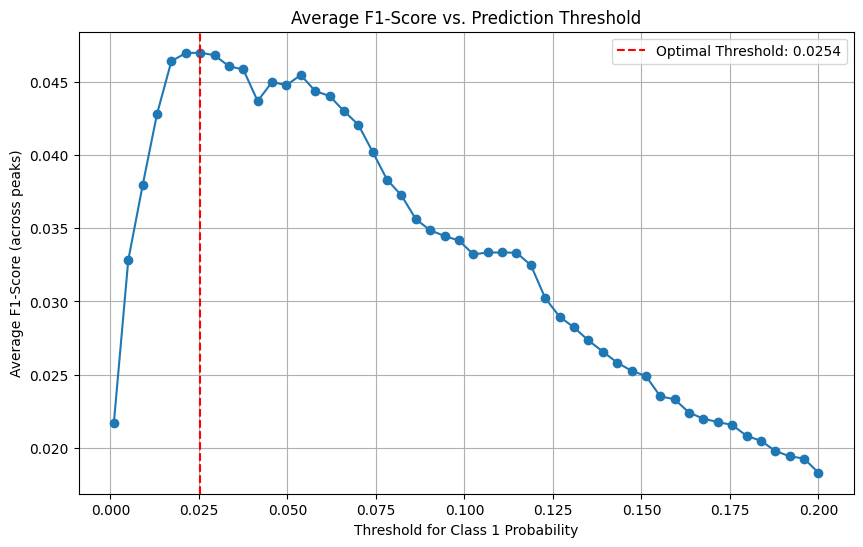


Calculating final metrics with optimal threshold: 0.0254
Final Average F1-Score (across all peaks): 0.0470
Final Average Precision (across all peaks): 0.0320
Final Average Recall (across all peaks): 0.1160
Final Average ROC AUC (across all peaks): 0.7918


In [115]:
# --- (Optional) Visualization of F1-score vs. Threshold ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores_per_threshold, marker='o', linestyle='-')
plt.title('Average F1-Score vs. Prediction Threshold')
plt.xlabel('Threshold for Class 1 Probability')
plt.ylabel('Average F1-Score (across peaks)')
plt.grid(True)
plt.axvline(x=best_overall_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {best_overall_threshold:.4f}')
plt.legend()
plt.show()

# --- Use the optimal threshold to calculate final metrics ---
print(f"\nCalculating final metrics with optimal threshold: {best_overall_threshold:.4f}")

final_f1_scores = []
final_precision_scores = []
final_recall_scores = []
final_roc_auc_scores = [] # ROC AUC doesn't change with threshold

for i in range(num_peaks):
    true_labels_peak = y_test[:, i]
    
    if y_pred_proba[i].shape[1] == 2:
        pred_proba_peak_positive = y_pred_proba[i][:, 1]
        has_two_classes_in_predictions = True
    else:
        pred_proba_peak_positive = np.zeros_like(true_labels_peak, dtype=float)
        has_two_classes_in_predictions = False

    # Apply the optimal threshold for binary predictions
    pred_labels_peak_optimal = (pred_proba_peak_positive >= best_overall_threshold).astype(int)

    final_f1_scores.append(f1_score(true_labels_peak, pred_labels_peak_optimal, zero_division=0))
    final_precision_scores.append(precision_score(true_labels_peak, pred_labels_peak_optimal, zero_division=0))
    final_recall_scores.append(recall_score(true_labels_peak, pred_labels_peak_optimal, zero_division=0))

    if len(np.unique(true_labels_peak)) > 1 and has_two_classes_in_predictions:
        final_roc_auc_scores.append(roc_auc_score(true_labels_peak, pred_proba_peak_positive))
    else:
        final_roc_auc_scores.append(np.nan) # Keep original ROC AUC calculation logic

print(f"Final Average F1-Score (across all peaks): {np.nanmean(final_f1_scores):.4f}")
print(f"Final Average Precision (across all peaks): {np.nanmean(final_precision_scores):.4f}")
print(f"Final Average Recall (across all peaks): {np.nanmean(final_recall_scores):.4f}")
print(f"Final Average ROC AUC (across all peaks): {np.nanmean(final_roc_auc_scores):.4f}")
